Alunos:

Alberto de Moraes Barbosa - amb3@cesar.school

Erick Anderson Ferreira Silva - eafs@cesar.school

Dataset escolhido:

Arabic Handwritten Characters Dataset (https://www.kaggle.com/datasets/mloey1/ahcd1)

# Treinamento com interface de alto nível

## Importação das bibliotecas

In [18]:
# http://pytorch.org/
from os.path import exists

import torch

In [19]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

In [20]:
#!/bin/bash
!curl -L -o /content/ahcd1.zip https://www.kaggle.com/api/v1/datasets/download/mloey1/ahcd1

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 23.9M  100 23.9M    0     0  14.2M      0  0:00:01  0:00:01 --:--:-- 17.7M


In [21]:
!unzip -o /content/ahcd1.zip -d /content/ahcd1

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: /content/ahcd1/train images 13440x32x32/train/id_5500_label_16.png  
  inflating: /content/ahcd1/train images 13440x32x32/train/id_5501_label_16.png  
  inflating: /content/ahcd1/train images 13440x32x32/train/id_5502_label_16.png  
  inflating: /content/ahcd1/train images 13440x32x32/train/id_5503_label_16.png  
  inflating: /content/ahcd1/train images 13440x32x32/train/id_5504_label_16.png  
  inflating: /content/ahcd1/train images 13440x32x32/train/id_5505_label_17.png  
  inflating: /content/ahcd1/train images 13440x32x32/train/id_5506_label_17.png  
  inflating: /content/ahcd1/train images 13440x32x32/train/id_5507_label_17.png  
  inflating: /content/ahcd1/train images 13440x32x32/train/id_5508_label_17.png  
  inflating: /content/ahcd1/train images 13440x32x32/train/id_5509_label_17.png  
  inflating: /content/ahcd1/train images 13440x32x32/train/id_550_label_13.png  
  inflating: /content/ahcd1/train images

In [22]:
ahcd1_train_img = "/content/ahcd1/Arabic Handwritten Characters Dataset CSV/csvTrainImages 13440x1024.csv"
ahcd1_train_label = "/content/ahcd1/Arabic Handwritten Characters Dataset CSV/csvTrainLabel 13440x1.csv"
ahcd1_test_img = "/content/ahcd1/Arabic Handwritten Characters Dataset CSV/csvTestImages 3360x1024.csv"
ahcd1_test_label = "/content/ahcd1/Arabic Handwritten Characters Dataset CSV/csvTestLabel 3360x1.csv"

In [23]:
x_train = pd.read_csv(ahcd1_train_img).values
x_train.shape

(13439, 1024)

In [24]:
y_train = pd.read_csv(ahcd1_train_label).values
y_train.shape

(13439, 1)

In [25]:
x_test = pd.read_csv(ahcd1_test_img).values
x_test.shape

(3359, 1024)

In [26]:
y_test = pd.read_csv(ahcd1_test_label).values
y_test.shape

(3359, 1)

In [27]:
arabic_characters = ['alef', 'beh', 'teh', 'theh', 'jeem', 'hah', 'khah', 'dal', 'thal',
                    'reh', 'zain', 'seen', 'sheen', 'sad', 'dad', 'tah', 'zah', 'ain',
                    'ghain', 'feh', 'qaf', 'kaf', 'lam', 'meem', 'noon', 'heh', 'waw', 'yeh']

In [28]:
class ahcd1Dataset(Dataset):
  def __init__(self, x, y):
    super(ahcd1Dataset, self).__init__()
    if(len(x) != len(y)):
      raise ValueError("Size de X e Y não dão match!")
    self.x = torch.FloatTensor(x)
    self.y = torch.LongTensor(y-1).flatten()
    self.x = torch.nan_to_num(self.x)
    self.y = torch.nan_to_num(self.y)

  def __getitem__(self, index):
     return self.x[index], self.y[index]

  def __len__(self):
    return len(self.x)

(13439, 32, 32, 1) (3359, 32, 32, 1)
[0 0 0 ... 0 0 0]


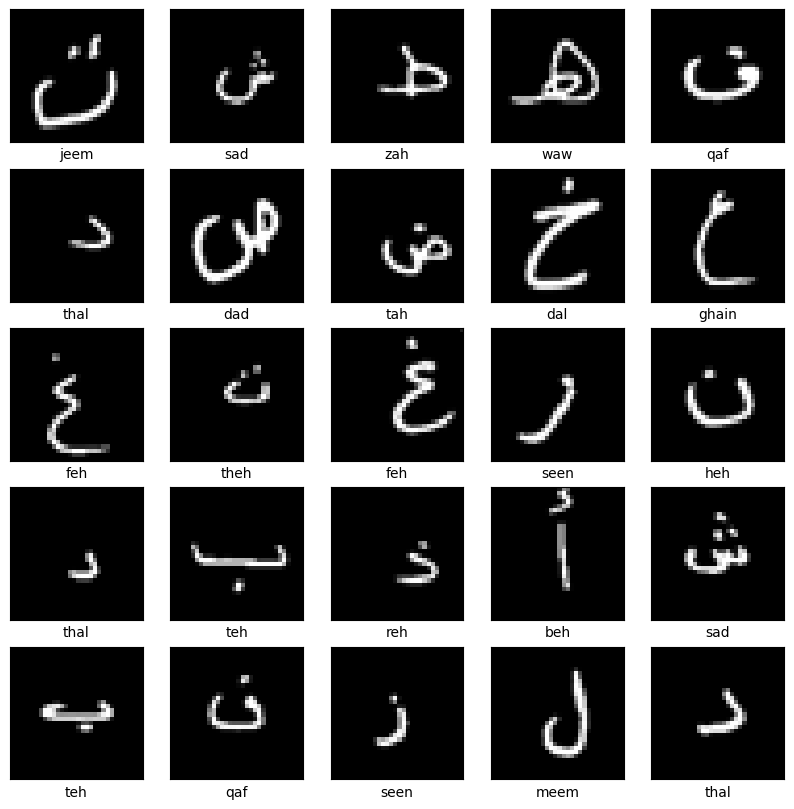

In [29]:
x_train_img = x_train.reshape(-1,32,32,1)
x_test_img = x_test.reshape(-1,32,32,1)

x_train_img = x_train_img / 255.0
x_test_img = x_test_img / 255.0

print(x_train_img.shape, x_test_img.shape)

ra = np.random.randint(0, 13439, size=25)
print(x_train[ra[0]])
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[ra[i]].reshape(32,32).T,"gray")
    plt.xlabel(arabic_characters[int(y_train[ra[i]][0])])
plt.show()

In [30]:
dataset_train = ahcd1Dataset(x_train, y_train)
dataset_test = ahcd1Dataset(x_test, y_test)

## Criação da rede

In [31]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, 28)
        )

    def forward(self, x):
        output = self.fc(x)
        return F.log_softmax(output, dim=1)

model = Net()

## Treinamento

### Criando o objeto de treinamento

In [32]:
def train(log_interval, dry_run, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if dry_run:
                break


In [33]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            #test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            test_loss += F.nll_loss(output, target)  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    acc = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        acc))
    return acc

## Avaliação

In [35]:
use_cuda = torch.cuda.is_available()

torch.manual_seed(1111)

device = torch.device("cuda" if use_cuda else "cpu")

train_kwargs = {'batch_size': 64}
test_kwargs = {'batch_size': 1000}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                    'pin_memory': True,
                    'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

#transform=transforms.Compose([
 #   transforms.ToTensor(),
  #  transforms.Normalize((0.1307,), (0.3081,))
  #  ])

train_loader = torch.utils.data.DataLoader(dataset_train,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset_test, **test_kwargs)

model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=0.6)

epochs = 14
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

for epoch in range(1, epochs + 1):
    train(10, False, model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

torch.save(model.state_dict(), "ahcd1_cnn.pt")

Train Epoch: 1 [0/13439 (0%)]	Loss: 11.615979
Train Epoch: 1 [640/13439 (5%)]	Loss: 3.444231
Train Epoch: 1 [1280/13439 (10%)]	Loss: 3.671512
Train Epoch: 1 [1920/13439 (14%)]	Loss: 4.159385
Train Epoch: 1 [2560/13439 (19%)]	Loss: 3.731821
Train Epoch: 1 [3200/13439 (24%)]	Loss: 2.905306
Train Epoch: 1 [3840/13439 (29%)]	Loss: 2.938227
Train Epoch: 1 [4480/13439 (33%)]	Loss: 2.771512
Train Epoch: 1 [5120/13439 (38%)]	Loss: 3.171531
Train Epoch: 1 [5760/13439 (43%)]	Loss: 2.891269
Train Epoch: 1 [6400/13439 (48%)]	Loss: 2.942154
Train Epoch: 1 [7040/13439 (52%)]	Loss: 3.087196
Train Epoch: 1 [7680/13439 (57%)]	Loss: 2.036290
Train Epoch: 1 [8320/13439 (62%)]	Loss: 2.433543
Train Epoch: 1 [8960/13439 (67%)]	Loss: 1.837698
Train Epoch: 1 [9600/13439 (71%)]	Loss: 2.492016
Train Epoch: 1 [10240/13439 (76%)]	Loss: 3.095417
Train Epoch: 1 [10880/13439 (81%)]	Loss: 2.660572
Train Epoch: 1 [11520/13439 (86%)]	Loss: 1.840361
Train Epoch: 1 [12160/13439 (90%)]	Loss: 1.802818
Train Epoch: 1 [12800

No pré-processamento dos dados o dataset, já dividia em base de treinamento e base de validação.
Neste trabalho usamos o código dado em aula para criar a rede predizer com uma uma acurácia de mais de 75% a classificação das imagens. Devido a não usarmos métodos como a convolução, que é um dos métodos muito usado para imagens, tivemos que simular com vários lr e até tamanhos de batch para alcançar um modelo com uma acurácia significativa.
